# PROJEKT 3 KRZYSZTOF KOWALSKI 407142

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
#!pip install segysak
from segysak.segy import segy_header_scan, segy_loader, get_segy_texthead
from sklearn.cluster import KMeans
#!pip install scikit-fuzzy
import skfuzzy as fuzz
from scipy.ndimage import generic_filter
from skimage.filters import sobel
from sklearn.preprocessing import StandardScaler

## 1. Wczytanie danych

In [4]:
headers = get_segy_texthead("TNE01_Full")
headers

Text HeaderC 1 SEGY OUTPUT FROM Petrel 2019.4 Wednesday, October 21 2020 14:19:53
C 2 Name: TNE01_FULL ÝRealized¨ 1 Type: 3D seismic
C 3
C 4 First inline: 362    Last inline: 1540
C 5 First xline:  908    Last xline:  3880
C 6 CRS: ST_ED50_UTM31N_P23031_T1133 ÝStatoil,2100005¨
C 7 X min: 531854.62 max: 563388.48 delta: 31533.86
C 8 Y min: 6731674.15 max: 6771202.25 delta: 39528.10
C 9 Time min: -4000.00 max: 4.00 delta: 4004.00
C10 Lat min: 60.42'51.1341"N max: 61.04'22.1371"N delta: 0.21'31.0031"
C11 Long min: 3.35'1.5768"E max: 4.10'28.3122"E delta: 0.35'26.7354"
C12 Trace min: -3998.00 max: 2.00 delta: 4000.00
C13 Seismic (template) min: -304.74 max: 302.36 delta: 607.11
C14 Amplitude (data) min: -304.74 max: 302.36 delta: 607.11
C15 Trace sample format: IEEE floating point
C16 Coordinate scale factor: 10.00000
C17
C18 Binary header locations:
C19 Sample interval             : bytes 17-18
C20 Number of samples per trace : bytes 21-22
C21 Trace date format           : bytes 25-26
C22
C23 Trace header locations:
C24 Inline number               : bytes 5-8
C25 Xline number                : bytes 21-24
C26 Coordinate scale factor     : bytes 71-72
C27 X coordinate                : bytes 73-76
C28 Y coordinate                : bytes 77-80
C29 Trace start time/depth      : bytes 109-110
C30 Number of samples per trace : bytes 115-116
C31 Sample interval             : bytes 117-118
C32
C33
C34
C35
C36
C37
C38
C39
C40 END EBCDIC

In [5]:
scan = segy_header_scan("TNE01_Full")
scan[scan["std"] > 0]

100%|██████████| 1.00k/1.00k [00:00<00:00, 10.4k traces/s]


byte_loc   count          mean           std         min  \
TRACE_SEQUENCE_LINE         1  1000.0  5.005000e+02    288.819436         1.0   
TraceNumber                13  1000.0  5.005000e+02    288.819436         1.0   
CDP                        21  1000.0  1.907000e+03    577.638872       908.0   
SourceX                    73  1000.0  5.570523e+06  36537.740701   5507333.0   
SourceY                    77  1000.0  6.749913e+07  62278.028634  67391426.0   
CDP_X                     181  1000.0  5.570523e+06  36537.740701   5507333.0   
CDP_Y                     185  1000.0  6.749913e+07  62278.028634  67391426.0   
CROSSLINE_3D              193  1000.0  1.907000e+03    577.638872       908.0   

                             25%         50%          75%         max  
TRACE_SEQUENCE_LINE       250.75       500.5       750.25      1000.0  
TraceNumber               250.75       500.5       750.25      1000.0  
CDP                      1407.50      1907.0      2406.50      2906.0  
SourceX               5538928.25   5570523.5   5602118.50   5633714.0  
SourceY              67445279.25  67499133.0  67552986.00  67606840.0  
CDP_X                 5538928.25   5570523.5   5602118.50   5633714.0  
CDP_Y                67445279.25  67499133.0  67552986.00  67606840.0  
CROSSLINE_3D             1407.50      1907.0      2406.50      2906.0

In [6]:
V3D = segy_loader("TNE01_Full", iline = 5, xline = 21, cdpx = 73, cdpy = 77, vert_domain = "TWT")
V3D

100%|██████████| 877k/877k [00:53<00:00, 16.3k traces/s]


Loading as 3D
Fast direction is TRACE_SEQUENCE_FILE


Converting SEGY:   0%|          | 0.00/877k [00:00<?, ? traces/s]C:\anaconda\Lib\site-packages\segysak\segy\_segy_loader.py:262: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape = [ds.dims[d] for d in dims]
Converting SEGY: 100%|██████████| 877k/877k [02:18<00:00, 6.32k traces/s]  


<xarray.Dataset> Size: 4GB
Dimensions:  (iline: 590, xline: 1487, twt: 1001)
Coordinates:
  * iline    (iline) uint16 1kB 362 364 366 368 370 ... 1532 1534 1536 1538 1540
  * xline    (xline) uint16 3kB 908 910 912 914 916 ... 3872 3874 3876 3878 3880
  * twt      (twt) float64 8kB -2.0 2.0 6.0 ... 3.99e+03 3.994e+03 3.998e+03
    cdp_x    (iline, xline) float32 4MB 5.634e+05 5.634e+05 ... 5.319e+05
    cdp_y    (iline, xline) float32 4MB 6.739e+06 6.739e+06 ... 6.764e+06
Data variables:
    data     (iline, xline, twt) float32 4GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/13)
    ns:                  None
    sample_rate:         4.0
    text:                C 1 SEGY OUTPUT FROM Petrel 2019.4 Wednesday, Octobe...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         TNE01_Full
    srd:                 None
    datatype:            None
    percentiles:         [-6.62317201331616e-68, -4.41544786148683e-68, -2.20...
    coord_scalar:        -10.0

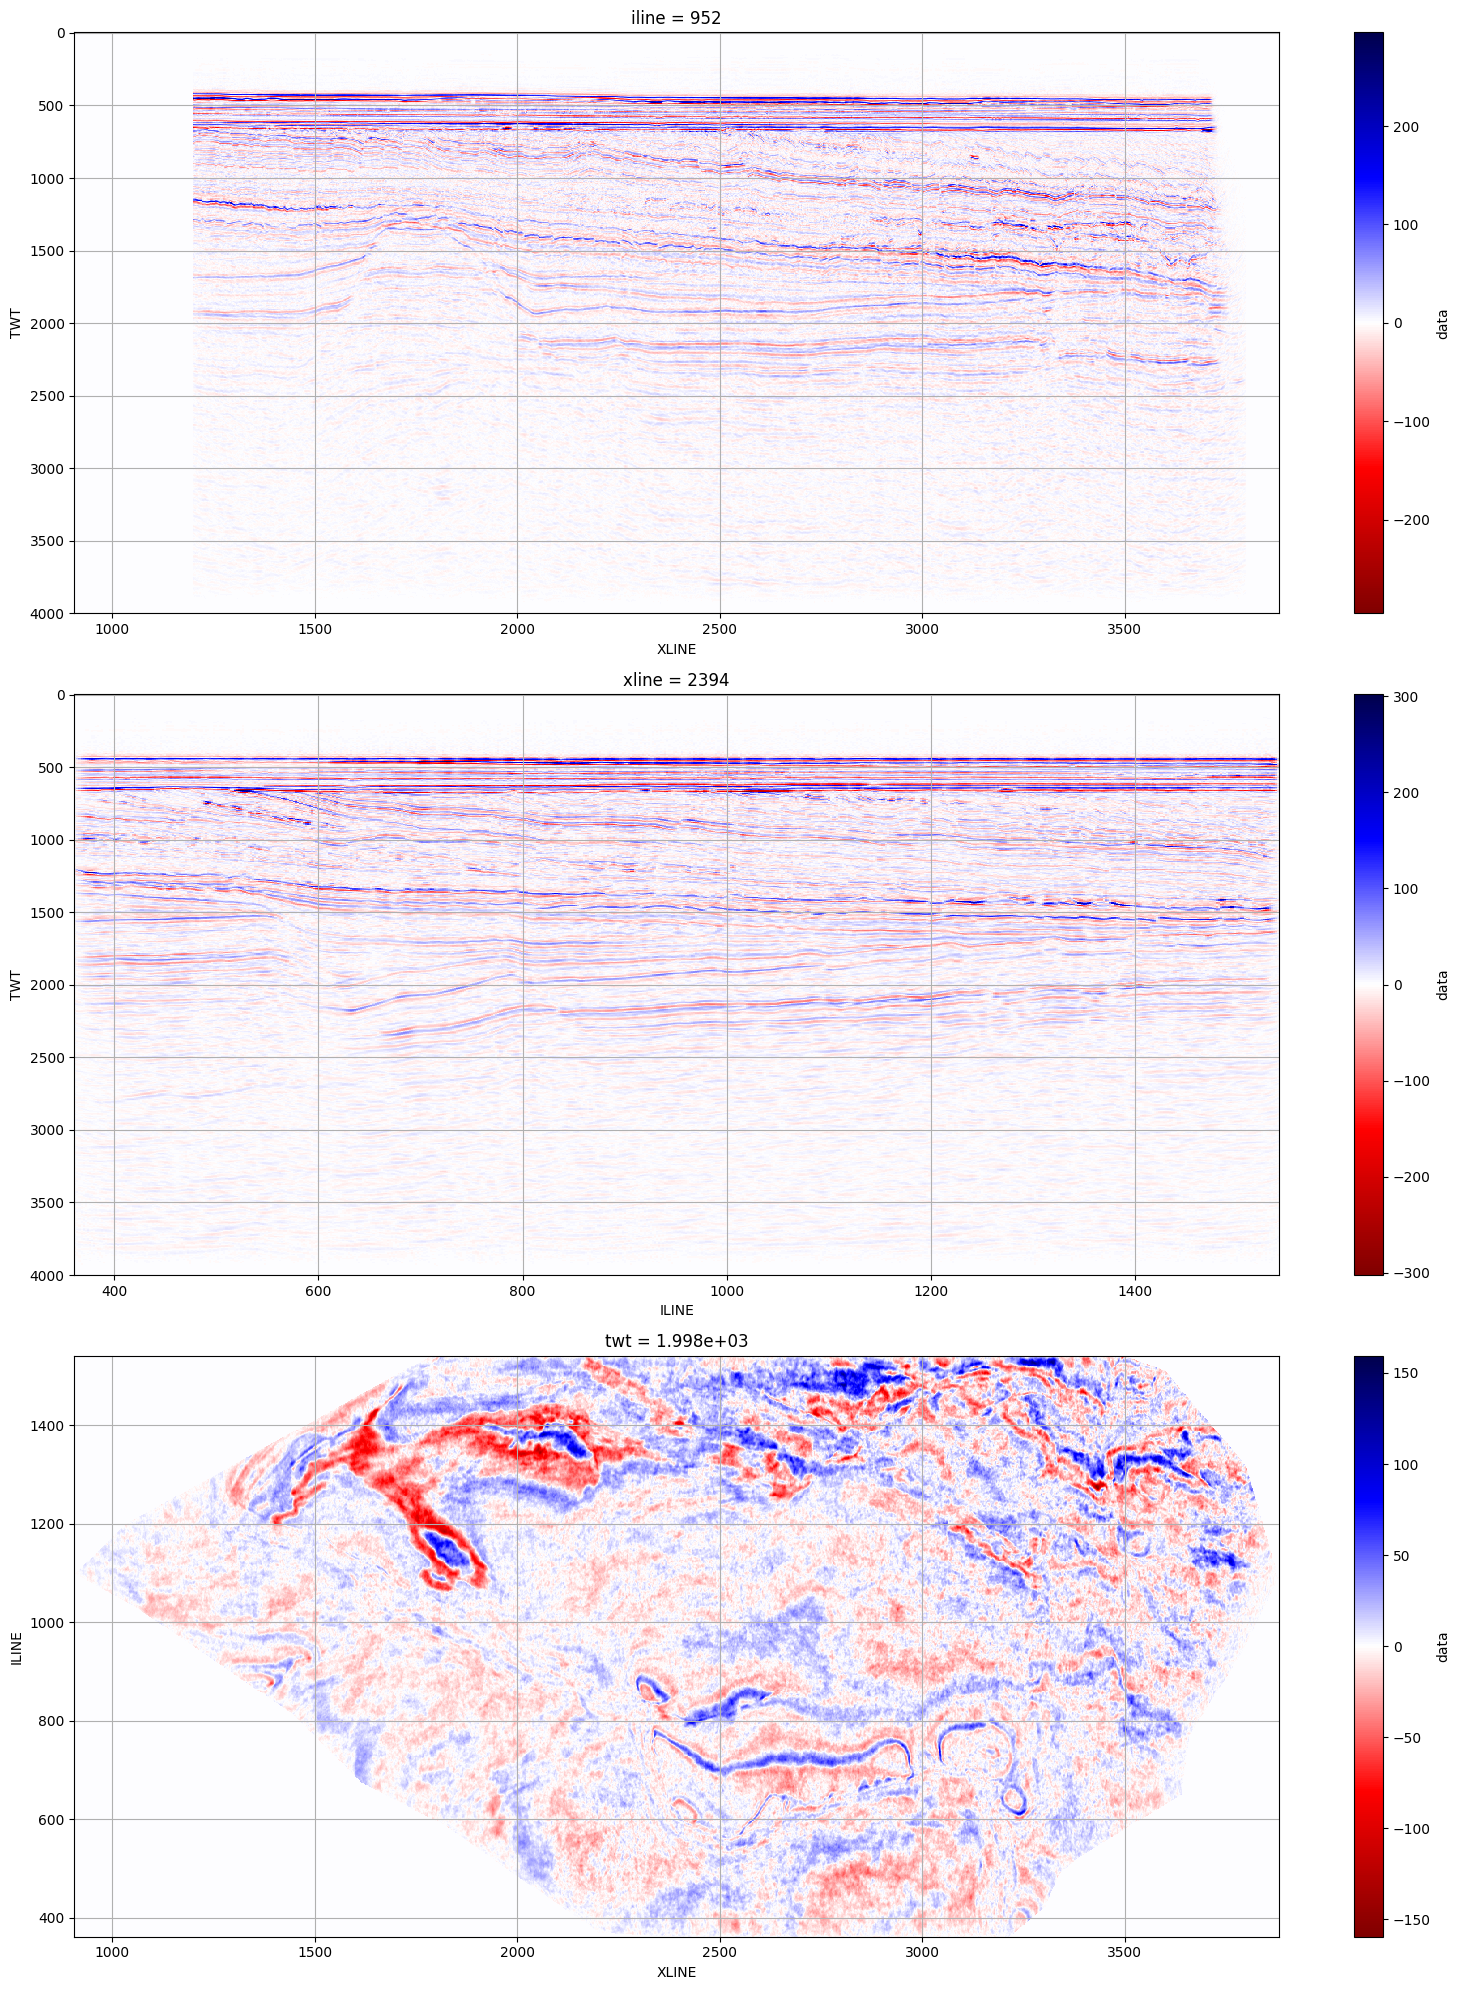

In [7]:
%matplotlib inline
fig, axes = plt.subplots(3, 1, figsize = [16, 20])
iline_mid = V3D.data.iline.median().values + 1
V3D.data.transpose("twt", "iline", "xline", transpose_coords = True).sel(iline = iline_mid).plot(yincrease = False, cmap = "seismic_r", ax = axes[0])
axes[0].grid("gray")
axes[0].set_xlabel("XLINE")
axes[0].set_ylabel("TWT")

xline_mid = V3D.data.xline.median().values
V3D.data.transpose("twt", "iline", "xline", transpose_coords = True).sel(xline = xline_mid).plot(yincrease = False, cmap = "seismic_r", ax = axes[1])
axes[1].grid("gray")
axes[1].set_xlabel("ILINE")
axes[1].set_ylabel("TWT")

twt_value_mid = V3D.data.twt.median().values
data_at_twt = V3D.data.sel(twt = twt_value_mid, method = "nearest").transpose("iline", "xline").plot(ax = axes[2], cmap = "seismic_r")
axes[2].grid("gray")
axes[2].set_xlabel("XLINE")
axes[2].set_ylabel("ILINE")

plt.tight_layout()

In [8]:
iline_range = (500, 1400)
xline_range = (2000, 3000)
twt_range = (1900, 2100)

In [9]:
cut = V3D.sel(iline = slice(iline_range[0], iline_range[1]), xline = slice(xline_range[0], xline_range[1]), twt = slice(twt_range[0], twt_range[1]))
cut

<xarray.Dataset> Size: 47MB
Dimensions:  (iline: 451, xline: 501, twt: 50)
Coordinates:
  * iline    (iline) uint16 902B 500 502 504 506 508 ... 1394 1396 1398 1400
  * xline    (xline) uint16 1kB 2000 2002 2004 2006 2008 ... 2994 2996 2998 3000
  * twt      (twt) float64 400B 1.902e+03 1.906e+03 ... 2.094e+03 2.098e+03
    cdp_x    (iline, xline) float32 904kB 5.55e+05 5.55e+05 ... 5.389e+05
    cdp_y    (iline, xline) float32 904kB 6.75e+06 6.75e+06 ... 6.755e+06
Data variables:
    data     (iline, xline, twt) float32 45MB -4.762 -2.381 0.0 ... 4.762 -14.28
Attributes: (12/13)
    ns:                  None
    sample_rate:         4.0
    text:                C 1 SEGY OUTPUT FROM Petrel 2019.4 Wednesday, Octobe...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         TNE01_Full
    srd:                 None
    datatype:            None
    percentiles:         [-6.62317201331616e-68, -4.41544786148683e-68, -2.20...
    coord_scalar:        -10.0

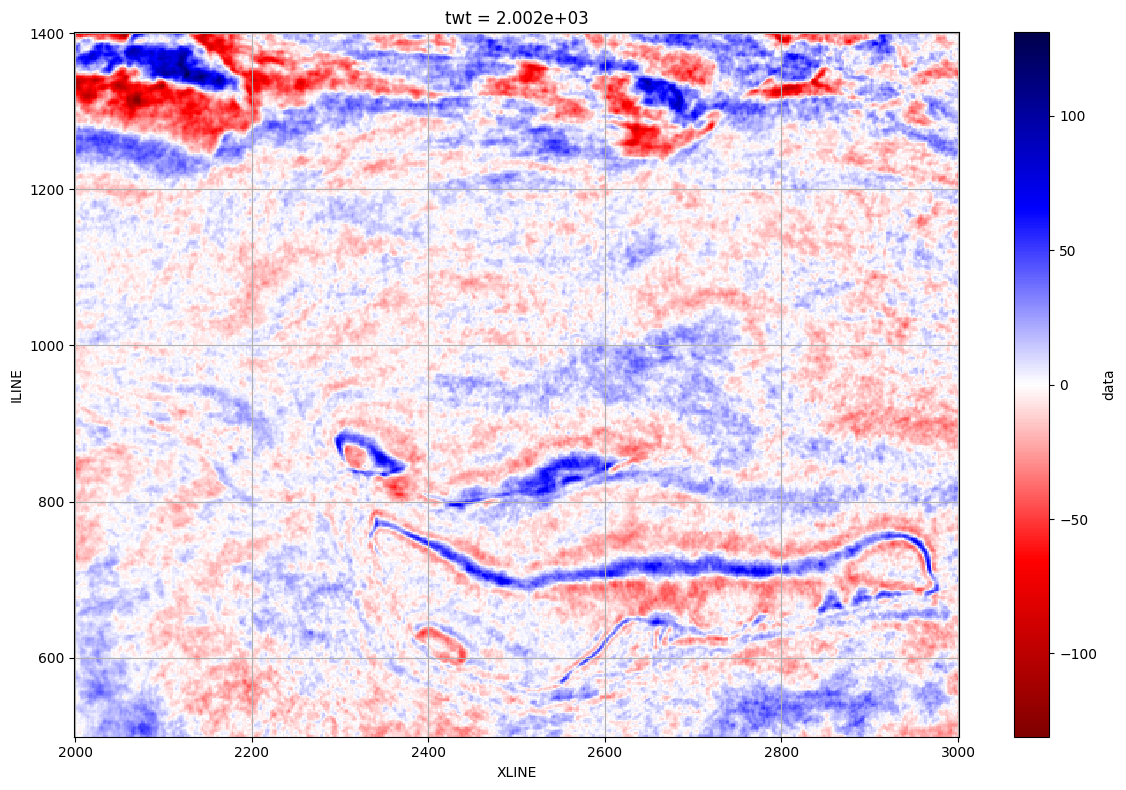

In [10]:
fig, axes = plt.subplots(1, 1, figsize = [12, 8])
twt_value_mid = cut.data.twt.median().values
data_at_twt = cut.data.sel(twt = twt_value_mid, method = "nearest").transpose("iline", "xline").plot(ax = axes, cmap = "seismic_r")
axes.grid("gray")
axes.set_xlabel("XLINE")
axes.set_ylabel("ILINE")
plt.tight_layout()

## 2. Konwersja xarray do numpy

In [12]:
numpy_cut = cut["data"].values

In [13]:
print(f'Smaller cube numpy dimension: {numpy_cut.shape}')

Smaller cube numpy dimension: (451, 501, 50)


In [14]:
numpy_cut[0]

array([[ -4.7616096,  -2.3808048,   0.       , ...,  -4.7616096,
         -7.1424146,  -2.3808048],
       [ -4.7616096,  -4.7616096,  -2.3808048, ...,  -7.1424146,
         -4.7616096,  -4.7616096],
       [ -7.1424146,  -4.7616096,  -4.7616096, ...,  -9.523219 ,
         -4.7616096,   0.       ],
       ...,
       [  4.7616096,  -2.3808048,  -4.7616096, ...,  -7.1424146,
         -2.3808048,   0.       ],
       [  7.1424146,   4.7616096,   0.       , ..., -11.904024 ,
         -2.3808048,   4.7616096],
       [  4.7616096,   0.       ,  -4.7616096, ...,  -7.1424146,
          0.       ,   2.3808048]], dtype=float32)

## 3. Klasteryzacja

### Różnice pomiędzy k-means a FCM
Główną różnicą pomiędzy tymi dwoma algorytmami jest przynależność konkretnego punktu do klastra. W k-means punkt albo należy albo nienależy do klastra, natomiast w FCM ten sam punkt może należeć do kilku klastrów z pewnym stopniem przynależności. 

Dodatkowo oba algorytmy posiadają inną funkcję celu. Zadaniem k-means jest zminimalizowanie sumy kwadratów odległości punktów od środka ich klastrów, natomiast celem FCM jest minimalizacja funkcji kosztu, która uwzględnia odległość punktów od centrów klastrów z uwzględnieniem wag przynależności.

### 2D

In [18]:
slice_index = 225
data_slice = numpy_cut[slice_index]

n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(data_slice.reshape(-1, 1))
kmeans_labels = kmeans.labels_.reshape(data_slice.shape)

data_flat = data_slice.flatten()
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data_flat.reshape(1, -1), n_clusters, 2, error = 0.005, maxiter = 1000)
fcm_labels = np.argmax(u, axis = 0).reshape(data_slice.shape)

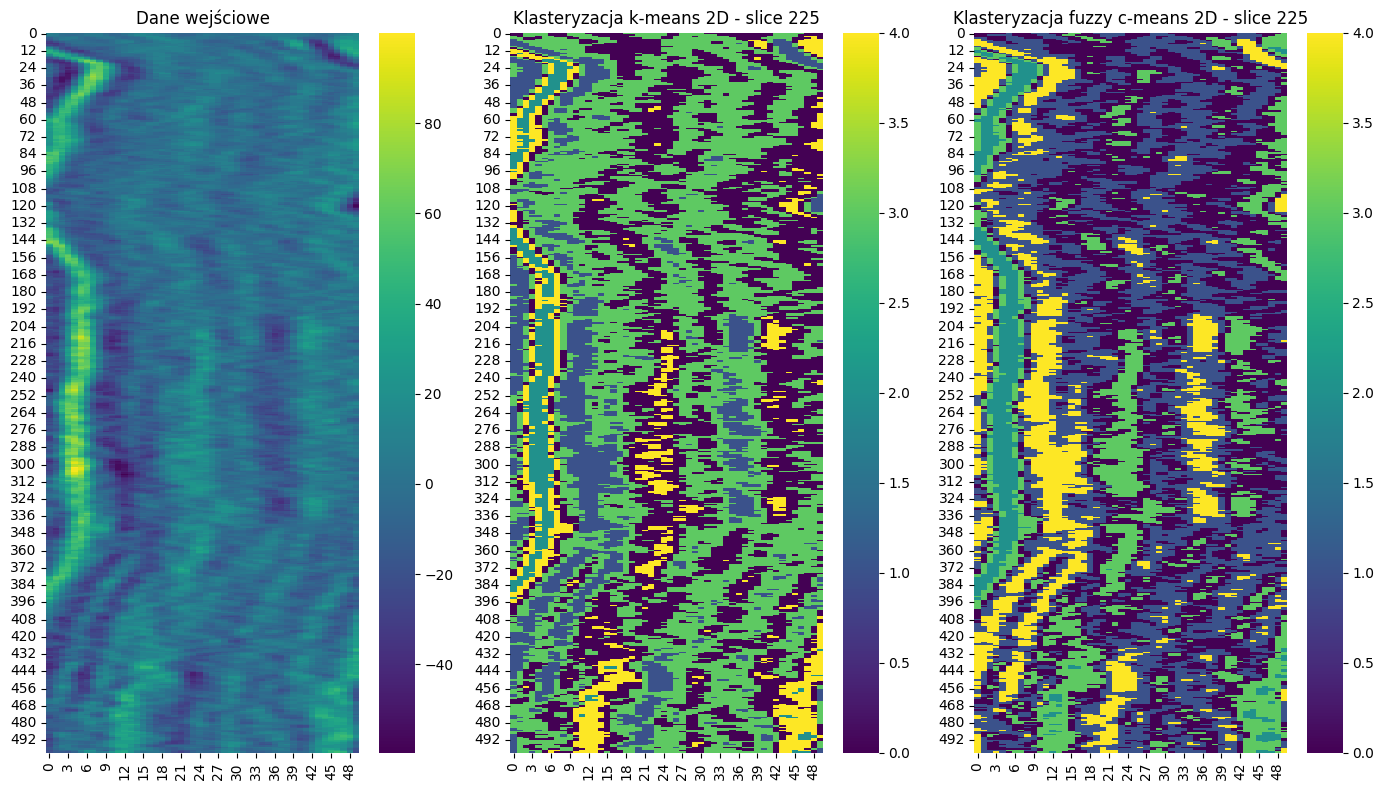

In [19]:
plt.figure(figsize = (14, 8))

plt.subplot(1, 3, 1)
sns.heatmap(data_slice, cmap = 'viridis', cbar = True)
plt.title("Dane wejściowe")

plt.subplot(1, 3, 2)
sns.heatmap(kmeans_labels, cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja k-means 2D - slice 225")

plt.subplot(1, 3, 3)
sns.heatmap(fcm_labels, cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja fuzzy c-means 2D - slice 225")

plt.tight_layout()

In [20]:
slice_index = 450
data_slice = numpy_cut[slice_index]

n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(data_slice.reshape(-1, 1))
kmeans_labels = kmeans.labels_.reshape(data_slice.shape)

data_flat = data_slice.flatten()
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data_flat.reshape(1, -1), n_clusters, 2, error = 0.005, maxiter = 1000)
fcm_labels = np.argmax(u, axis = 0).reshape(data_slice.shape)

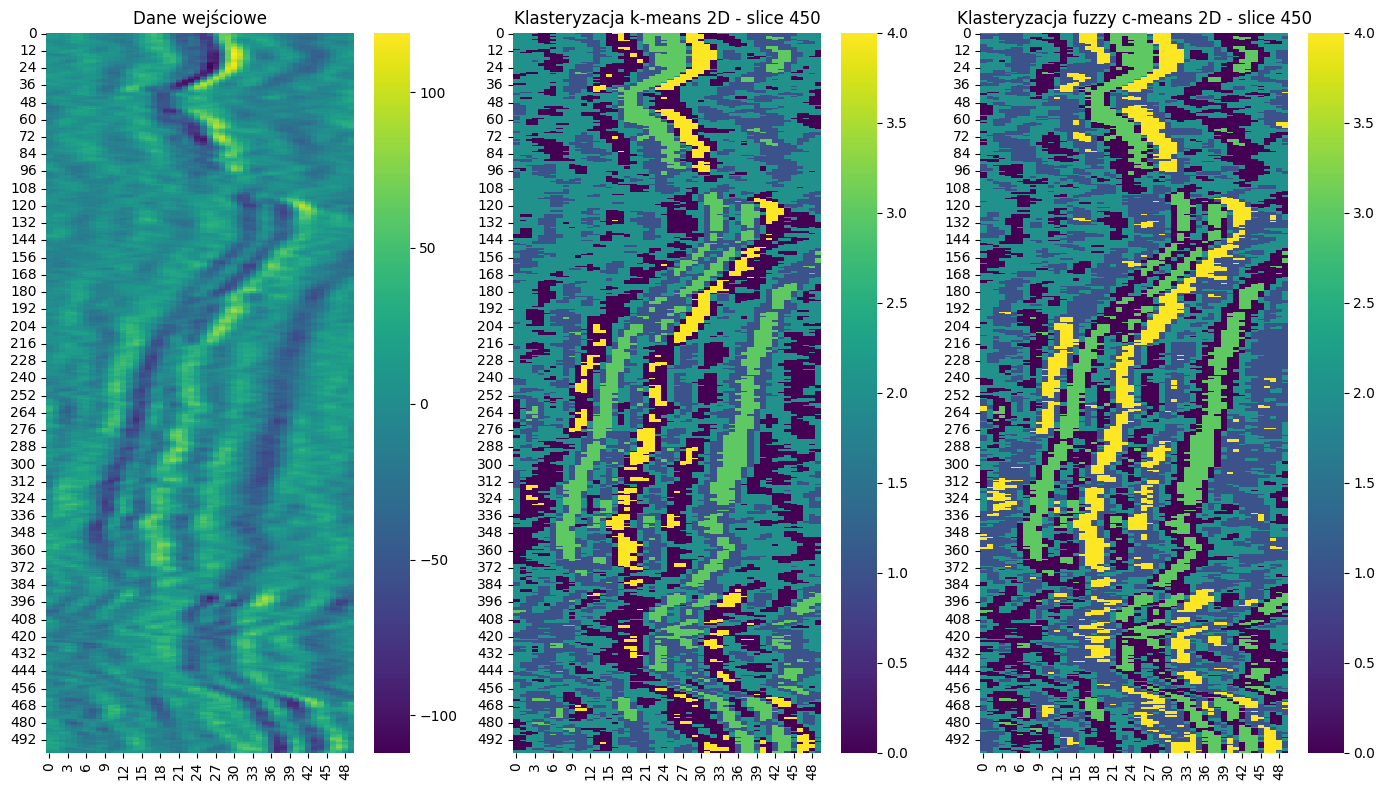

In [21]:
plt.figure(figsize = (14, 8))

plt.subplot(1, 3, 1)
sns.heatmap(data_slice, cmap = 'viridis', cbar = True)
plt.title("Dane wejściowe")

plt.subplot(1, 3, 2)
sns.heatmap(kmeans_labels, cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja k-means 2D - slice 450")

plt.subplot(1, 3, 3)
sns.heatmap(fcm_labels, cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja fuzzy c-means 2D - slice 450")

plt.tight_layout()

### 3D

In [23]:
slice_index = 225

data_3d = numpy_cut.reshape(-1, 1)
n_clusters = 5
kmeans_3d = KMeans(n_clusters = n_clusters, random_state = 0).fit(data_3d)
kmeans_labels_3d = kmeans_3d.labels_.reshape(numpy_cut.shape)

cntr_3d, u_3d, _, _, _, _, _ = fuzz.cluster.cmeans(data_3d.T, n_clusters, 2, error = 0.005, maxiter = 1000)
fcm_labels_3d = np.argmax(u_3d, axis = 0).reshape(numpy_cut.shape)

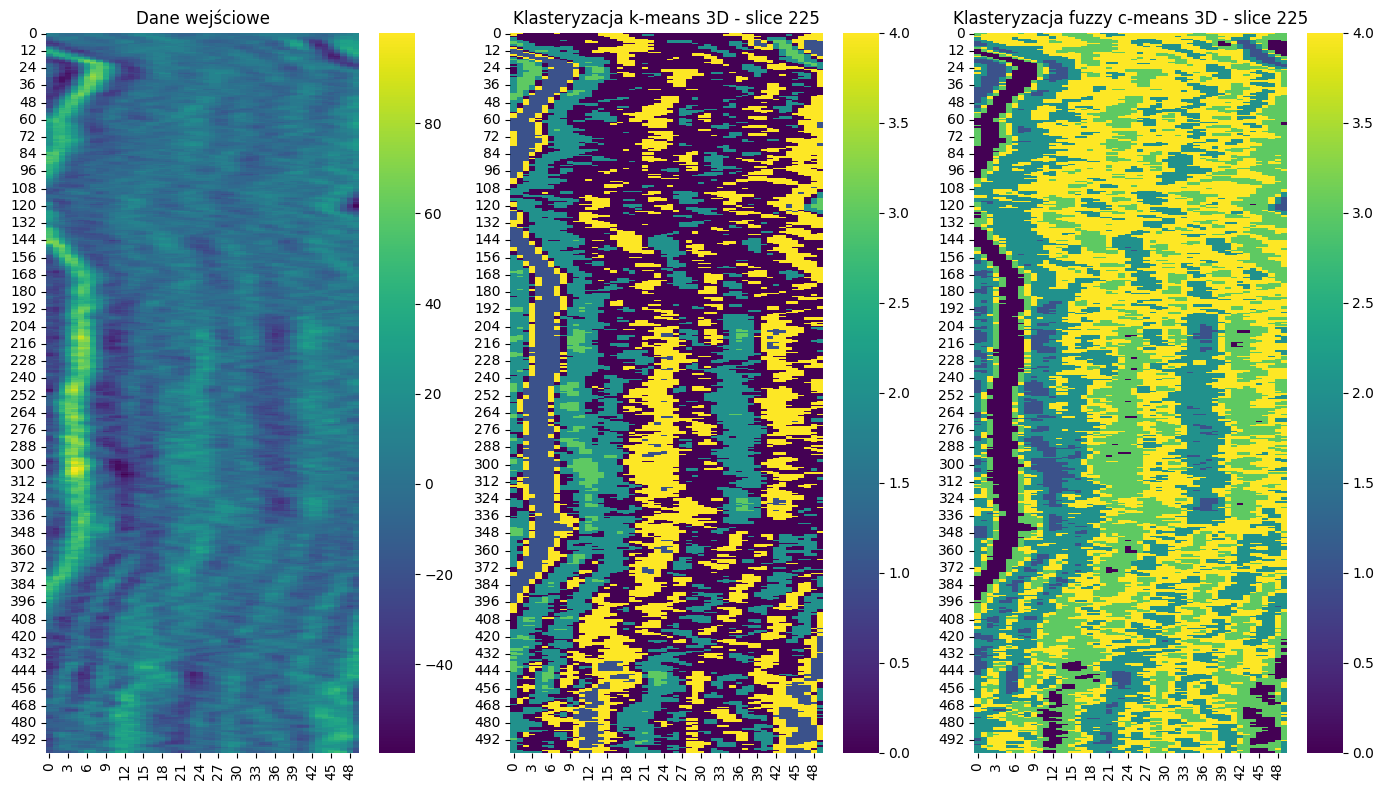

In [24]:
plt.figure(figsize = (14, 8))

plt.subplot(1, 3, 1)
sns.heatmap(numpy_cut[slice_index], cmap = 'viridis', cbar = True)
plt.title("Dane wejściowe")

plt.subplot(1, 3, 2)
sns.heatmap(kmeans_labels_3d[slice_index], cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja k-means 3D - slice 225")

plt.subplot(1, 3, 3)
sns.heatmap(fcm_labels_3d[slice_index], cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja fuzzy c-means 3D - slice 225")

plt.tight_layout()

In [25]:
slice_index = 450

data_3d = numpy_cut.reshape(-1, 1)
n_clusters = 5
kmeans_3d = KMeans(n_clusters = n_clusters, random_state = 0).fit(data_3d)
kmeans_labels_3d = kmeans_3d.labels_.reshape(numpy_cut.shape)

cntr_3d, u_3d, _, _, _, _, _ = fuzz.cluster.cmeans(data_3d.T, n_clusters, 2, error = 0.005, maxiter = 1000)
fcm_labels_3d = np.argmax(u_3d, axis = 0).reshape(numpy_cut.shape)

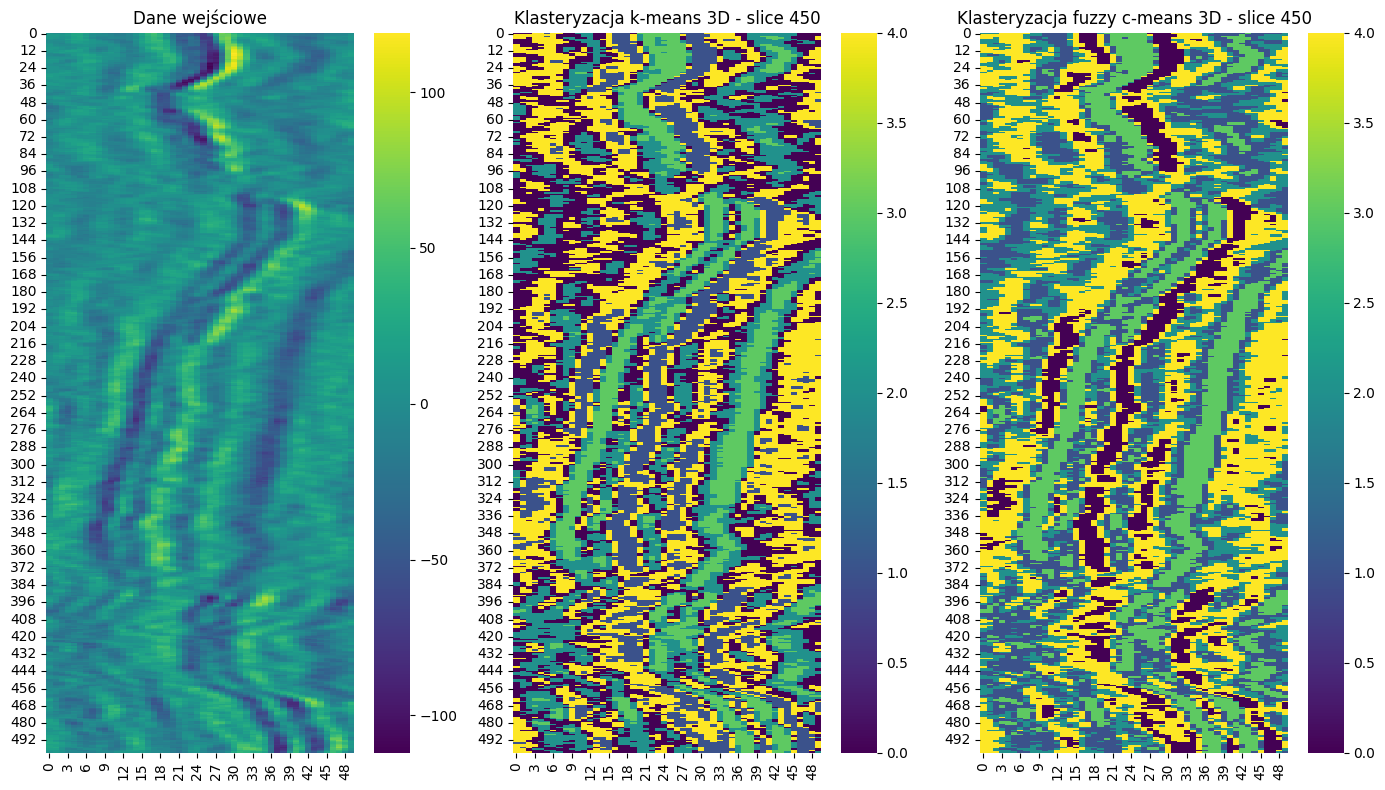

In [26]:
plt.figure(figsize = (14, 8))

plt.subplot(1, 3, 1)
sns.heatmap(numpy_cut[slice_index], cmap = 'viridis', cbar = True)
plt.title("Dane wejściowe")

plt.subplot(1, 3, 2)
sns.heatmap(kmeans_labels_3d[slice_index], cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja k-means 3D - slice 450")

plt.subplot(1, 3, 3)
sns.heatmap(fcm_labels_3d[slice_index], cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja fuzzy c-means 3D - slice 450")

plt.tight_layout()

## Porównanie

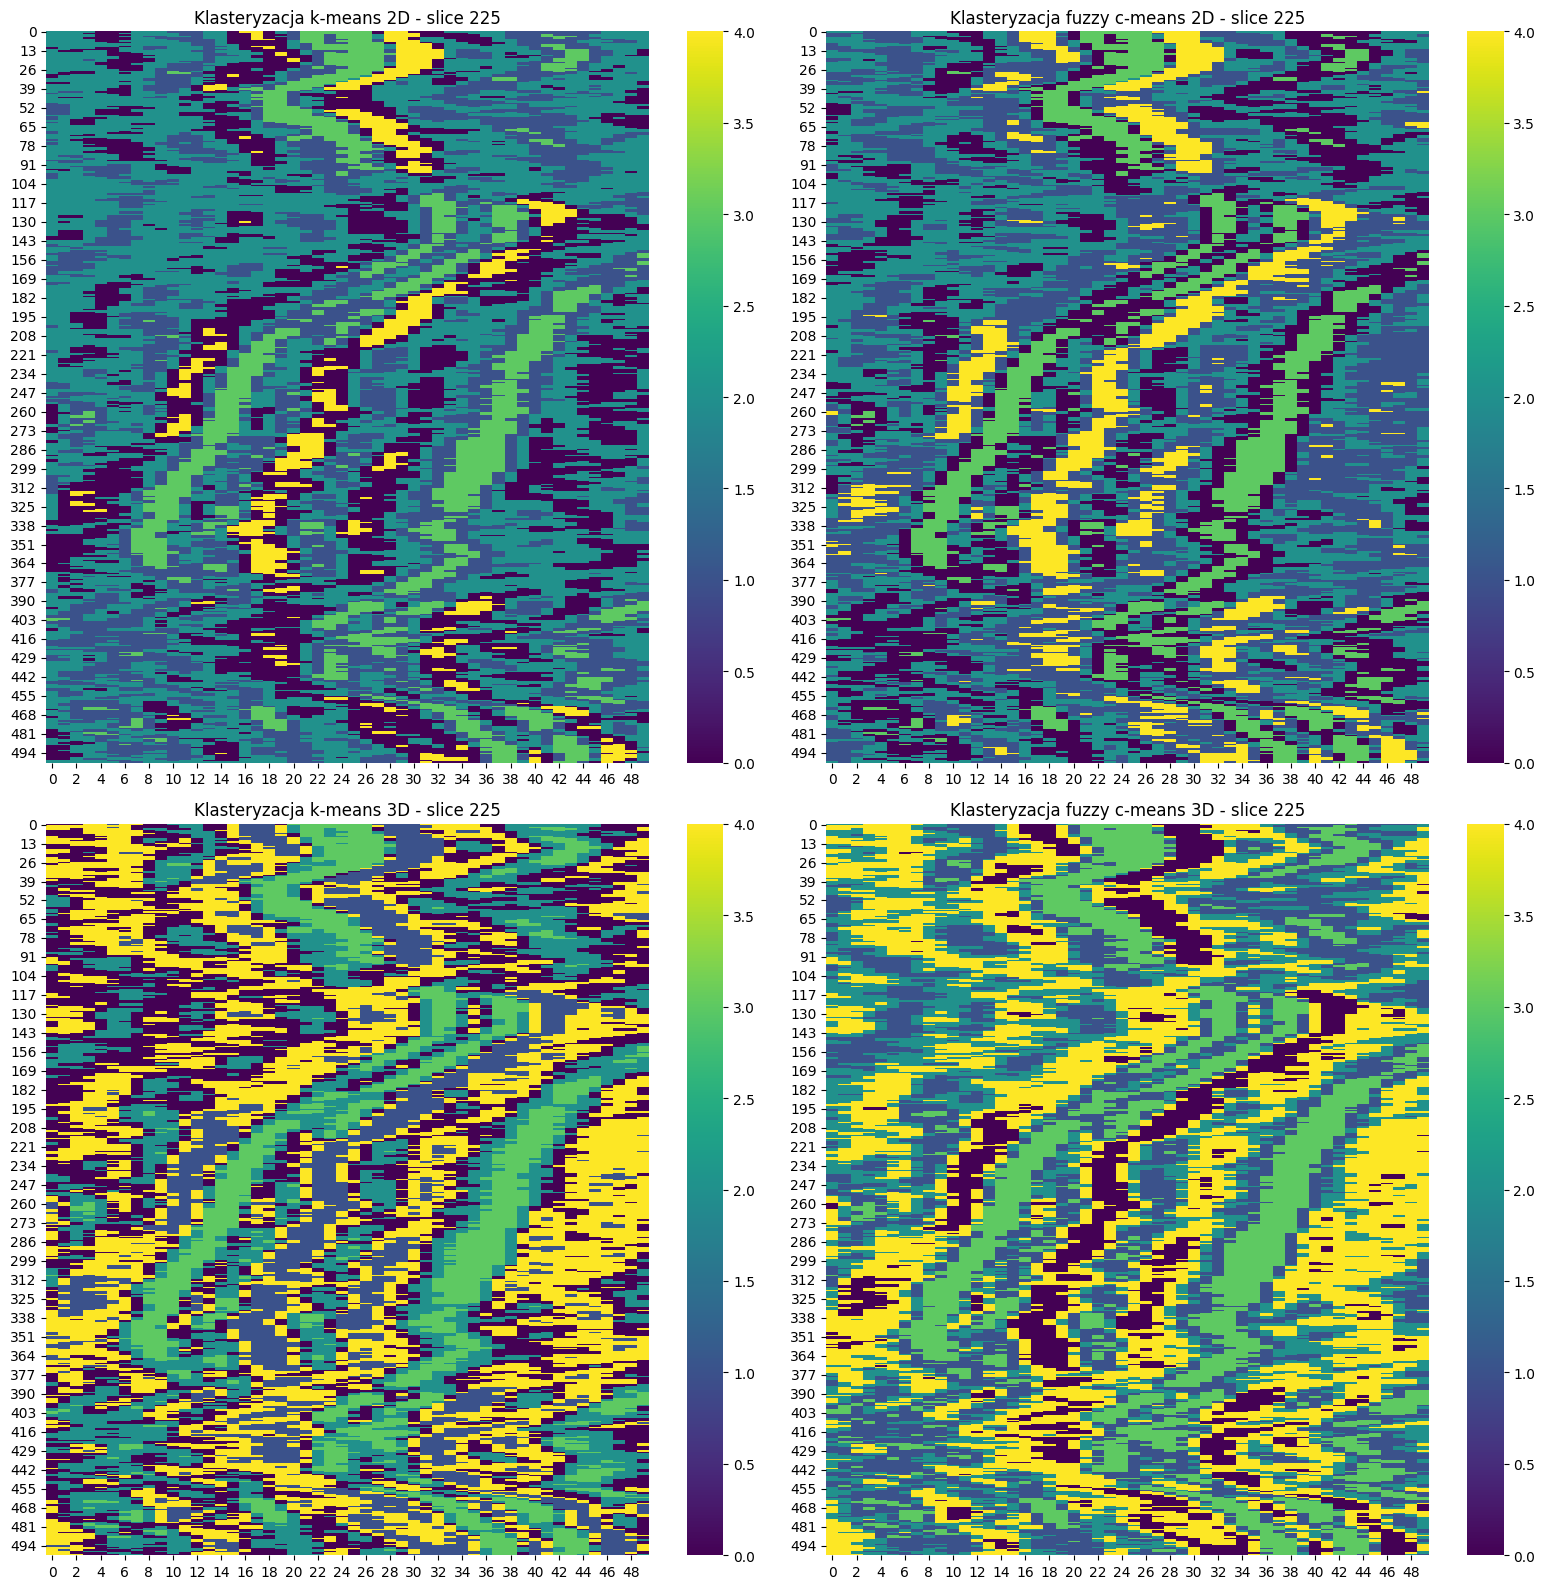

In [28]:
plt.figure(figsize = (16, 16))

plt.subplot(2, 2, 1)
sns.heatmap(kmeans_labels, cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja k-means 2D - slice 225")

plt.subplot(2, 2, 2)
sns.heatmap(fcm_labels, cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja fuzzy c-means 2D - slice 225")

plt.subplot(2, 2, 3)
sns.heatmap(kmeans_labels_3d[slice_index], cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja k-means 3D - slice 225")

plt.subplot(2, 2, 4)
sns.heatmap(fcm_labels_3d[slice_index], cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja fuzzy c-means 3D - slice 225")

plt.tight_layout()

## 4. Dodatkowe atrybuty

In [30]:
def mean_filter(data, size=3):
    return generic_filter(data, np.mean, size=size)

def std_filter(data, size=3):
    return generic_filter(data, np.std, size=size)

def max_amplitude_filter(data, size=3):
    return generic_filter(data, np.max, size=size)

In [32]:
slice_index = 225
data_slice = numpy_cut[slice_index]

mean_data = mean_filter(data_slice)
std_data = std_filter(data_slice)
max_amplitude_data = max_amplitude_filter(data_slice)

features = np.stack((data_slice, mean_data, std_data, max_amplitude_data), axis = -1)
features_reshaped = features.reshape(-1, features.shape[-1])

scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_reshaped)

n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(features_normalized)
kmeans_labels_attr = kmeans.labels_.reshape(data_slice.shape)

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(features_normalized.T, n_clusters, 2, error = 0.005, maxiter = 1000)
fcm_labels_attr = np.argmax(u, axis = 0).reshape(data_slice.shape)

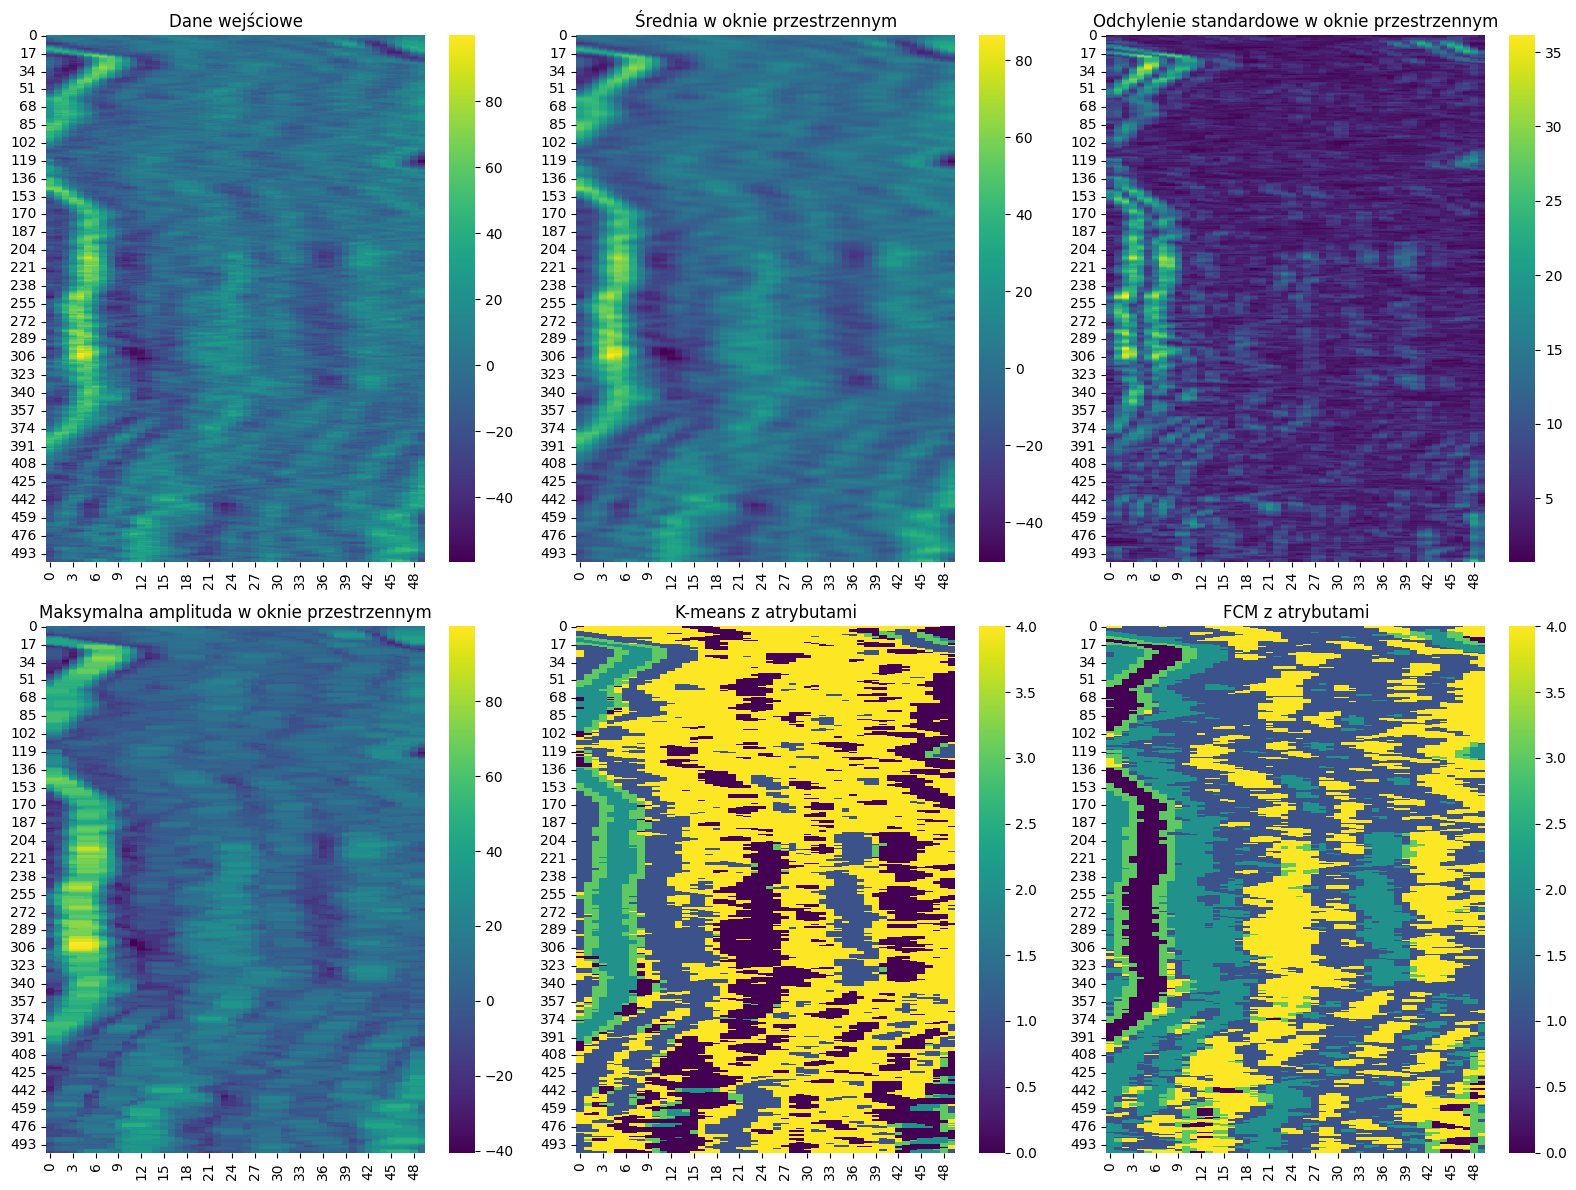

In [33]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
sns.heatmap(data_slice, cmap = 'viridis', cbar = True)
plt.title("Dane wejściowe")

plt.subplot(2, 3, 2)
sns.heatmap(mean_data, cmap = 'viridis', cbar = True)
plt.title("Średnia w oknie przestrzennym")

plt.subplot(2, 3, 3)
sns.heatmap(std_data, cmap = 'viridis', cbar = True)
plt.title("Odchylenie standardowe w oknie przestrzennym")

plt.subplot(2, 3, 4)
sns.heatmap(max_amplitude_data, cmap = 'viridis', cbar = True)
plt.title("Maksymalna amplituda w oknie przestrzennym")

plt.subplot(2, 3, 5)
sns.heatmap(kmeans_labels_attr, cmap = 'viridis', cbar = True)
plt.title("K-means z atrybutami")

plt.subplot(2, 3, 6)
sns.heatmap(fcm_labels_attr, cmap = 'viridis', cbar = True)
plt.title("FCM z atrybutami")

plt.tight_layout()

### Wszystkie razem

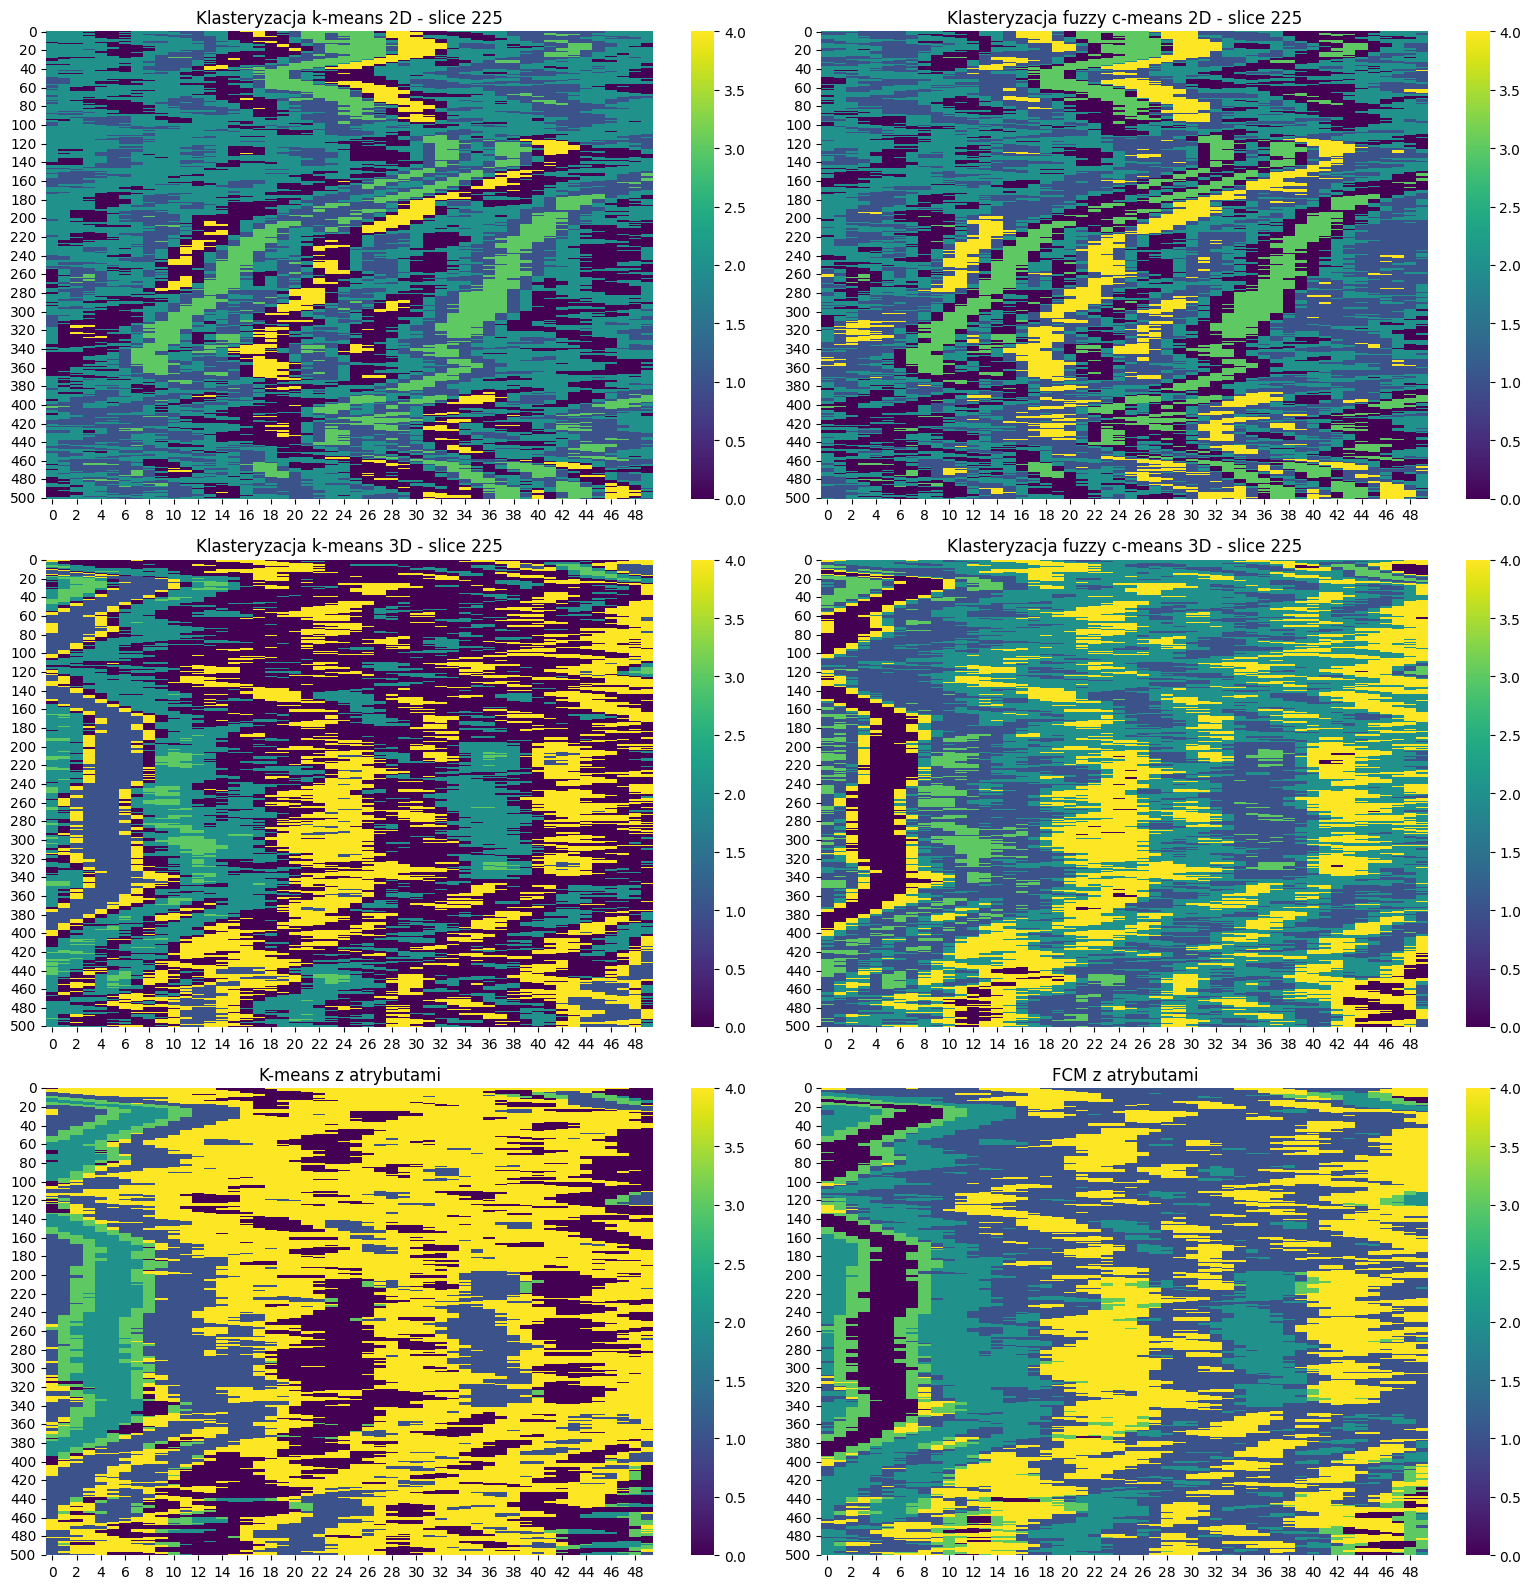

In [36]:
plt.figure(figsize = (16, 16))

plt.subplot(3, 2, 1)
sns.heatmap(kmeans_labels, cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja k-means 2D - slice 225")

plt.subplot(3, 2, 2)
sns.heatmap(fcm_labels, cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja fuzzy c-means 2D - slice 225")

plt.subplot(3, 2, 3)
sns.heatmap(kmeans_labels_3d[slice_index], cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja k-means 3D - slice 225")

plt.subplot(3, 2, 4)
sns.heatmap(fcm_labels_3d[slice_index], cmap = 'viridis', cbar = True)
plt.title("Klasteryzacja fuzzy c-means 3D - slice 225")

plt.subplot(3, 2, 5)
sns.heatmap(kmeans_labels_attr, cmap = 'viridis', cbar = True)
plt.title("K-means z atrybutami")

plt.subplot(3, 2, 6)
sns.heatmap(fcm_labels_attr, cmap = 'viridis', cbar = True)
plt.title("FCM z atrybutami")

plt.tight_layout()

## 5. Wnioski
- Widać znaczne różnice pomiędzy dwoma metodami - zarówno wykonując klasteryzacje na slice'ach jak i na całości. Mimo, że różnice widoczne są na obu na całych danych różnica ta jest jeszcze lepiej widoczna.
- Bazując na danych wejściowych obie metody dobrze radzą sobie z klasteryzacją.
- Metoda 3D zwraca wyniki mniej różnorodne (co może powodować pominięcie części kluczowych informacji).
- Metoda 3D jest bardziej złożona obliczeniowo, a co za tym idzie jest również bardziej czasochłonna.
- Dodanie dodatkowych atrybutów miało znaczący wpływ dla algorytmu k-means oraz FCM. Wpływ na FCM oceniam pozytywnie (lepsze rozróznienie klastrów), natomiast dla k-means zniekształciło to miejsca znalezienia klastrów. Gdybym po raz kolejny miał dokonać klasteryzacji skorzystałbym z opcji bez dodatkowymi atrybutami dla FCM.